# Flow Matching for Antibody CDR Design

In this small project, we want to see if we are able to to "reconstruct" a loop of a single antibody. We focus on the H3 loop since it is the most variable and functionally important loop.
For this we want to use a flow matching approach, which learns the smooth vector field that moves noisy coordinates toward a realistic loop conformation, aligning with physical intuition of folding.
This small project is currently a proof of concept rather than a full-scale model training effort, because it focuses on a single antibody (e.g., hu-4D5-8_Fv) and uses it to test the feasibility of conditional flow matching for antibody loop generation, rather than training a generalizable model across a large dataset.

### Setup

In [1]:
# @title
!pip install -q biopython torch numpy
from google.colab import drive, userdata
import os, subprocess, json, math, random, torch
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from torch import nn
from Bio.PDB import PDBParser
from IPython.display import clear_output
from time import time

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Flow_Matching')
PDB_PATH = "hu-4D5-8_Fv.pdb"

# H3 loop residues are mentioned in th PDB file. (99-105)
CHAIN_ID = "H"            # "H" or "L"
LOOP_START = 99           # EDIT these to your loop window
LOOP_END   = 105          # inclusive

# Training hyperparams
SEED = 42
BATCH = 64
STEPS = 2000
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

SAVE_DIR = "flow_cdr_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)
print("Using device:", DEVICE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6.6 MB/s eta 0:00:00
Mounted at /content/drive
Using device: cpu


### Functions for Training

In [2]:
# @title
def load_ca_coords(pdb_path, chain_id, loop_start, loop_end):
    """
    This function loads the 3D coordinates of both the loop and the framework regions
    of an antibody from a PDB structure.

    Inputs:
      - pdb_path (str): Path to the relevant PDB file, e.g. "hu-4D5-8_Fv.pdb".
      - chain_id (str): Chain identifier to extract, e.g. "H" for the heavy chain.
                        (Not strictly needed if residue numbering is unique.)
      - loop_start (int): Residue number where the selected loop starts.
      - loop_end (int): Residue number where the selected loop ends (inclusive).

    Returns:
      - loop_xyz (np.ndarray): 3D coordinates (Å) of the loop Cα atoms, shape [L,3].
      - fw_xyz (np.ndarray): 3D coordinates (Å) of the framework Cα atoms, shape [F,3].
      - loop_resids (list[int]): Residue numbers corresponding to the loop residues.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("ab", pdb_path)
    model = list(structure)[0]
    chain = model[chain_id]
    loop_xyz = []
    loop_resids = []
    fw_xyz = []
    for res in chain:
        if "CA" not in res:
            continue
        ca = res["CA"].get_vector().get_array()
        resid = res.id[1]
        if loop_start <= resid <= loop_end:
            loop_xyz.append(ca)
            loop_resids.append(resid)
        else:
            fw_xyz.append(ca)
    loop_xyz = np.array(loop_xyz, dtype=np.float32)
    fw_xyz = np.array(fw_xyz, dtype=np.float32) if fw_xyz else np.zeros((0,3), np.float32)
    assert loop_xyz.shape[0] == (loop_end - loop_start + 1), \
        f"Expected {loop_end-loop_start+1} loop residues, found {loop_xyz.shape[0]}. Check indices."

    return loop_xyz, fw_xyz, loop_resids

def canonical_frame_from_fw(fw_xyz: np.ndarray):
    """
    Computes the canonical (relative) reference frame from the framework coordinates.

    Inputs:
      - fw_xyz (np.ndarray): [N,3] array of absolute 3D coordinates (Å) of the framework Cα atoms.

    Returns:
      - fw_center (np.ndarray): [3] centroid of the framework used for translation.
      - U (np.ndarray): [3,3] right-handed rotation matrix (PCA-based with sign corrections)
                        defining the canonical orientation.
    """
    if fw_xyz.shape[0] == 0:
        # Degenerate case: no framework -> identity
        return np.zeros(3, np.float32), np.eye(3, dtype=np.float32)

    fw_center = fw_xyz.mean(axis=0).astype(np.float32)
    fw_c = (fw_xyz - fw_center).astype(np.float32)

    cov = fw_c.T @ fw_c
    vals, vecs = np.linalg.eigh(cov)
    order = np.argsort(vals)[::-1]
    U = vecs[:, order].astype(np.float32)

    # sign disambiguation on first axis
    ref = fw_c.mean(axis=0)
    if np.linalg.norm(ref) < 1e-8:
        ref = np.array([1.0, 0.0, 0.0], np.float32)
    if float(np.dot(U[:,0], ref)) < 0.0:
        U[:,0] *= -1.0

    # ensure right-handed; repair if nearly collinear
    third = np.cross(U[:,0], U[:,1])
    if np.linalg.norm(third) < 1e-8:
        tmp = np.array([0.0, 1.0, 0.0], np.float32)
        if abs(float(np.dot(tmp, U[:,0]))) > 0.9:
            tmp = np.array([0.0, 0.0, 1.0], np.float32)
        U[:,1] = (tmp - float(np.dot(tmp, U[:,0])) * U[:,0])
        U[:,1] /= (np.linalg.norm(U[:,1]) + 1e-12)
        third = np.cross(U[:,0], U[:,1])
    U[:,2] = third / (np.linalg.norm(third) + 1e-12)
    if np.linalg.det(U) < 0:
        U[:,1] *= -1.0; U[:,2] *= -1.0
    return fw_center, U

def apply_canonical(X: np.ndarray, fw_center: np.ndarray, U: np.ndarray):
    """
    Transforms absolute coordinates into canonical (relative) coordinates
    by centering and rotating using the framework reference frame.

    Inputs:
      - X (np.ndarray): [N,3] array of absolute 3D coordinates (Å).
      - fw_center (np.ndarray): [3] framework centroid.
      - U (np.ndarray): [3,3] canonical rotation matrix.

    Returns:
      - X_rel (np.ndarray): [N,3] canonical (relative) coordinates.
    """
    return (X - fw_center) @ U

def invert_canonical(X_rel: np.ndarray, fw_center: np.ndarray, U: np.ndarray):
    """
    Converts canonical (relative) coordinates back into absolute 3D coordinates
    by applying the inverse rotation and translation.

    Inputs:
      - X_rel (np.ndarray): [N,3] canonical (relative) coordinates.
      - fw_center (np.ndarray): [3] framework centroid.
      - U (np.ndarray): [3,3] canonical rotation matrix.

    Returns:
      - X_abs (np.ndarray): [N,3] absolute 3D coordinates (Å).
    """
    return X_rel @ U.T + fw_center

class ContextEmbed(nn.Module):
    """
    NN module that encodes 3D framework coordinates into a fixed-length embedding.

    Purpose:
      - To transform variable-length framework residue coordinates [N,3] into
        a compact context vector [B,128] summarizing the framework geometry.
      - This embedding serves as the "context" input for the conditional flow model.

    Architecture:
      - MLP: (3 → 64 → 128 → 128)
      - Activation: SiLU (Smooth ReLU)
      - Pooling: Global max pooling across residue dimension (N)
      - Post MLP: (128 → 128) for nonlinear refinement

    Inputs:
      - fw (Tensor): Framework coordinates of shape [B,N,3] or [N,3].
                     B = batch size, N = number of residues.

    Returns:
      - context_emb (Tensor): Framework embedding of shape [B,128].
    """
    def __init__(self, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3,64), nn.SiLU(),
            nn.Linear(64,128), nn.SiLU(),
            nn.Linear(128, out_dim)
        )
        self.post = nn.Sequential(nn.Linear(out_dim, out_dim), nn.SiLU())

    def forward(self, fw):
        if fw.ndim == 2: fw = fw.unsqueeze(0)
        h = self.mlp(fw)
        h = h.max(dim=1).values
        return self.post(h)

class TimeEmbed(nn.Module):
    """
    Encodes the time variable τ (0→1) into a higher-dimensional vector.

    Purpose:
      - Provides the flow network with information about "where along the trajectory" we are.
      - Transforms scalar time t into a learned 128-D representation suitable for conditioning.

    Architecture:
      - MLP: 1 → 128 → 128
      - Activation: SiLU (Smooth ReLU)

    Inputs:
      - t (Tensor): Time values of shape [B] or [B,1].

    Returns:
      - t_emb (Tensor): Time embeddings of shape [B, 128].
    """
    def __init__(self, dim=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1,128), nn.SiLU(), nn.Linear(128,dim), nn.SiLU())
    def forward(self, t):
        if t.ndim == 1: t = t[:,None]
        return self.net(t)


class FlowNet(nn.Module):
    """
    Neural network predicting the 3D velocity field of loop atoms during the flow process.

    Purpose:
      - Learns v_theta(x_tau, t, context): how each atom should move at time τ.
      - Combines loop coordinates, time, and framework context into one representation.

    Architecture:
      - Input: flattened loop coordinates [L*3], time embedding [128], context embedding [128]
      - MLP: (L*3 + 128 + 128) → 512 → 512 → (L*3)
      - Activation: SiLU

    Inputs:
      - x_tau (Tensor): Loop coordinates at current time step [B,L,3]
      - t (Tensor): Time values [B] or [B,1]
      - ctx (Tensor): Framework embeddings [B, ctx_dim]

    Returns:
      - v (Tensor): Predicted velocity vectors [B,L,3]
                    Each v[b,i,:] is the model’s estimated change for residue i.
    """
    def __init__(self, L, ctx_dim=128, hidden=512):
        super().__init__()
        self.temb = TimeEmbed(128)
        D = L*3
        self.net = nn.Sequential(
            nn.Linear(D + 128 + ctx_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, D)
        )
    def forward(self, x_tau, t, ctx):
        B = x_tau.shape[0]
        xt = x_tau.reshape(B,-1)
        h = torch.cat([xt, self.temb(t), ctx], dim=-1)
        v = self.net(h).reshape(B,-1,3)
        return v # [B,L,3]

def sample_batch(batch=BATCH, jitter=0.3, noise_scale=3.0):
    """
    Generates a batch of training samples for flow matching.

    Inputs:
      - batch (int): Number of examples per batch.
      - jitter (float): Amount of random Gaussian noise added to the target structure
                        (for data augmentation).
      - noise_scale (float): Scale of the starting noise cloud (distance from the target).

    Returns:
      - x_s (Tensor): Noisy starting coordinates [B,L,3].
      - x_t (Tensor): Jittered target coordinates [B,L,3].
      - x_tau (Tensor): Interpolated coordinates at random time τ [B,L,3].
      - u_star (Tensor): True flow direction (x_t - x_s) [B,L,3].
      - tau (Tensor): Random time values in (0,1) [B].
    """
    x_t = gt + torch.randn((batch,)+gt.shape[1:], device=DEVICE)*jitter
    x_s = torch.randn_like(x_t)*noise_scale
    tau = torch.rand((batch,), device=DEVICE).clamp(1e-3, 1-1e-3)
    x_tau = (1.0 - tau)[:,None,None]*x_s + tau[:,None,None]*x_t
    u_star = (x_t - x_s)  # straight path target flow
    return x_s, x_t, x_tau, u_star, tau


def cfm_step():
    """
    Performs one optimization (training) step of the Conditional Flow Matching (CFM) model.

    This function:
      1. Samples a batch of noisy and target loop structures via `sample_batch()`.
      2. Encodes the framework coordinates into a fixed-length context vector using `ctx_net`.
      3. Predicts the velocity field at intermediate points x_tau using the flow network `flow`.
      4. Computes the mean squared error (MSE) loss between the predicted and true velocities.

    Inputs:
      - (uses global variables)
        • fw_rel (np.ndarray): Canonicalized framework coordinates [N,3].
        • ctx_net (nn.Module): Context embedding network (ContextEmbed).
        • flow (nn.Module): Flow network predicting velocity fields (FlowNet).
        • DEVICE (torch.device): CPU or GPU device for computation.

    Returns:
      - loss (torch.Tensor): Mean squared error between predicted and true velocities (scalar).
    """
    x_s, x_t, x_tau, u_star, tau = sample_batch()
    if fw_rel.size:
        fw_torch = torch.tensor(fw_rel, dtype=torch.float32, device=DEVICE)[None].repeat(BATCH,1,1)
    else:
        fw_torch = torch.zeros((BATCH,1,3), dtype=torch.float32, device=DEVICE)
    ctx = ctx_net(fw_torch)
    v_pred = flow(x_tau, tau, ctx)
    loss = ((v_pred - u_star)**2).mean()
    return loss

## Extrapolating the loop and creating the different NNs

In [3]:
loop_xyz, fw_xyz, loop_resids = load_ca_coords(PDB_PATH, CHAIN_ID, LOOP_START, LOOP_END)
L = loop_xyz.shape[0]
print("Loop length L:", L, "Loop resids:", loop_resids, "Framework CA:", fw_xyz.shape)
fw_center, U = canonical_frame_from_fw(fw_xyz)
fw_rel   = apply_canonical(fw_xyz,   fw_center, U)
loop_rel = apply_canonical(loop_xyz, fw_center, U)
# Creating the context embedding NN
ctx_net = ContextEmbed(128).to(DEVICE)
# Creating the main NN
flow = FlowNet(L, 128, 512).to(DEVICE)
opt = torch.optim.AdamW(list(flow.parameters())+list(ctx_net.parameters()), lr=LR)
gt = torch.tensor(loop_rel, dtype=torch.float32, device=DEVICE)
gt = gt[None, ...]

Loop length L: 7 Loop resids: [99, 100, 101, 102, 103, 104, 105] Framework CA: (109, 3)


### Training

In [4]:
flow.train(); ctx_net.train()
t0=time()
loss_hist=[]
for step in range(1, STEPS+1):
    loss = cfm_step()
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    loss_hist.append(float(loss.detach().cpu()))
    if step%100==0 or step==1:
        print(f"step {step:4d} | loss {loss.item():.4f}")
print("Done in %.1fs" % (time()-t0))

step    1 | loss 92.3081
step  100 | loss 8.3826
step  200 | loss 6.1146
step  300 | loss 4.0287
step  400 | loss 2.6997
step  500 | loss 2.2817
step  600 | loss 2.5181
step  700 | loss 1.1830
step  800 | loss 1.7055
step  900 | loss 2.2555
step 1000 | loss 1.8582
step 1100 | loss 1.7522
step 1200 | loss 2.1279
step 1300 | loss 1.5882
step 1400 | loss 1.9083
step 1500 | loss 1.9859
step 1600 | loss 1.7915
step 1700 | loss 1.5780
step 1800 | loss 2.2954
step 1900 | loss 1.2129
step 2000 | loss 2.7920
Done in 114.8s


### Loop Generation Functions

In [5]:
# @title
@torch.no_grad()
def sample(
    n=5, steps=50, noise_scale=3.0,
    return_traj=False,           # True to record intermediate x's (for plotting)
    fw_center=None, U=None,      # If provided, also return absolute coords
):
    """
    Generates loop structures by integrating the learned flow field starting from random noise.

    The function begins from unstructured 3D noise and follows the predicted velocity field
    for a series of small steps to progressively form structured loops.
    Optionally, it can record the full trajectory and/or convert canonical coordinates
    back to absolute coordinates if the framework reference frame is provided. Integration
    done using a simple Euler scheme.

    Inputs:
      - n (int): Number of independent loops to generate.
      - steps (int): Number of Euler integration steps along the learned flow.
      - noise_scale (float): Magnitude of initial random noise (defines starting dispersion).
      - return_traj (bool): If True, records and returns intermediate coordinates at each step.
      - fw_center (np.ndarray or torch.Tensor, optional): [3] framework centroid used to
        convert canonical coordinates back to absolute coordinates.
      - U (np.ndarray or torch.Tensor, optional): [3,3] canonical rotation matrix of the
        framework used for conversion to absolute coordinates.

    Returns:
      - x (torch.Tensor): [n,L,3] final generated loop coordinates in canonical frame.
      - traj (list[torch.Tensor], optional): Sequence of intermediate canonical coordinates
        if `return_traj=True`.
      - x_abs (torch.Tensor, optional): [n,L,3] final generated loop coordinates converted
        to absolute coordinates (if fw_center and U are provided).
      - traj_abs (list[torch.Tensor], optional): Intermediate absolute coordinates
        corresponding to the full trajectory (if available).

    Notes:
      - The model (`flow`, `ctx_net`) is switched to evaluation mode (`.eval()`).
      - Integration is performed using a simple Euler scheme.
      - If both `fw_center` and `U` are provided, results are returned in both canonical
        and absolute coordinate frames; otherwise, only canonical coordinates are returned.
    """
    # switching networks to evaluation mode
    flow.eval(); ctx_net.eval()

    # creating completely unstructured random positions (in the canonical frame)
    x = torch.randn((n, L, 3), device=DEVICE) * noise_scale  # x(t=0)

    # build framework batch in the same canonical frame
    if fw_rel.size:
        fw_t = torch.tensor(fw_rel, dtype=torch.float32, device=DEVICE)[None].repeat(n,1,1)
    else:
        fw_t = torch.zeros((n,1,3), dtype=torch.float32, device=DEVICE)

    # runs the context encoder on the framework geometry to get an embedding
    ctx = ctx_net(fw_t)  # fixed context

    # time setup
    t = torch.zeros((n,), device=DEVICE)
    dt = 1.0 / steps

    traj = [x.clone()] if return_traj else None

    for k in range(steps):
        # Euler step along predicted vector field
        v0 = flow(x, t, ctx)
        x = x + v0 * dt
        t = torch.clamp(t + dt, 0.0, 1.0)

        if return_traj:
            traj.append(x.clone())

    # x is still centered on fw_center and rotated by U (canonical frame)
    # Optionally convert back to absolute coordinates if fw_center & U were provided
    x_abs = None
    traj_abs = None
    if (fw_center is not None) and (U is not None):
        # torch versions of center/rotation
        fw_c = torch.as_tensor(fw_center, dtype=torch.float32, device=x.device)  # [3]
        U_t  = torch.as_tensor(U, dtype=torch.float32, device=x.device)          # [3,3]
        x_abs = x @ U_t.T + fw_c  # [n,L,3]

        if return_traj:
            traj_abs = [X @ U_t.T + fw_c for X in traj]

    if return_traj:
        return x, traj, x_abs, traj_abs  # (canonical, canonical_traj, absolute, absolute_traj)
    else:
        return x if x_abs is None else x_abs   # return absolute if we can fw_center
    return x

In [6]:
samples = sample(n=8, steps=100, fw_center=fw_center, U=U).cpu().numpy()
print("Samples:", samples.shape)  # [N,L,3]

Samples: (8, 7, 3)


### Evaluation & Utils Functions

In [7]:
# @title
def kabsch_align(P, Q):
    """
    Performs Kabsch alignment of point set P onto Q and computes RMSD.

    Inputs:
      - P (np.ndarray): [N,3] source coordinates.
      - Q (np.ndarray): [N,3] target coordinates.

    Returns:
      - P_aligned (np.ndarray): [N,3] aligned version of P (superimposed onto Q).
      - rmsd (float): Root Mean Square Deviation between P_aligned and Q (Å).
    """
    P = np.asarray(P, dtype=np.float64)
    Q = np.asarray(Q, dtype=np.float64)
    assert P.shape == Q.shape and P.shape[1] == 3
    Pc = P - P.mean(axis=0, keepdims=True)
    Qc = Q - Q.mean(axis=0, keepdims=True)
    C = Pc.T @ Qc
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(V @ Wt))
    R = V @ np.diag([1,1,d]) @ Wt
    P_aligned = Pc @ R
    diff = P_aligned - Qc
    rmsd = np.sqrt((diff*diff).sum()/P.shape[0])
    P_aligned += Q.mean(axis=0, keepdims=True)
    return P_aligned, float(rmsd)

def kabsch_rmsd(P,Q):
    """
    Computes only the RMSD between two coordinate sets after optimal Kabsch alignment.

    Inputs:
      - P (np.ndarray): [N,3] source coordinates.
      - Q (np.ndarray): [N,3] target coordinates.

    Returns:
      - rmsd (float): Root Mean Square Deviation between optimally aligned P and Q (Å).
    """
    return kabsch_align(P,Q)[1]

def ca_bond_stats(ca_xyz, ideal=3.8, tol=0.5):
    """
    Evaluates Cα–Cα bond length quality in a loop or structure.

    Inputs:
      - ca_xyz (np.ndarray): [L,3] Cα coordinates.
      - ideal (float): Ideal Cα–Cα bond distance (Å). Default: 3.8.
      - tol (float): Allowed deviation from the ideal distance (Å). Default: 0.5.

    Returns:
      - valid (float): Fraction of consecutive bonds within [ideal ± tol].
      - mad (float): Mean absolute deviation from the ideal distance (Å).
    """
    ca = np.asarray(ca_xyz, dtype=np.float64)
    if len(ca) < 2:
        return 1.0, 0.0
    d = np.linalg.norm(ca[1:] - ca[:-1], axis=1)
    valid = np.logical_and(d > (ideal - tol), d < (ideal + tol)).mean()
    mad = np.abs(d - ideal).mean()
    return float(valid), float(mad)

def clash_count_ca(loop_ca, fw_ca, thresh=2.5):
    """
    Counts steric clashes (too-close Cα–Cα distances) between loop and framework atoms.

    Inputs:
      - loop_ca (np.ndarray): [L,3] loop Cα coordinates.
      - fw_ca (np.ndarray): [F,3] framework Cα coordinates.
      - thresh (float): Clash distance threshold in Å (default: 2.5).

    Returns:
      - clash_count (int): Number of inter-atomic pairs closer than the threshold.
    """
    if fw_ca is None or len(fw_ca)==0:
        return 0
    L = np.asarray(loop_ca, dtype=np.float64)
    F = np.asarray(fw_ca, dtype=np.float64)
    diff = L[:,None,:] - F[None,:,:]
    dist = np.linalg.norm(diff, axis=2)
    return int((dist < thresh).sum())

def baseline_jittered_native_can(loop_rel, n=32, jitter=0.3, seed=0):
    """
    Creates baseline samples by jittering the canonical ground-truth loop.

    Inputs:
      - loop_rel (np.ndarray): [L,3] canonical ground-truth loop coordinates.
      - n (int): Number of jittered samples to generate. Default: 32.
      - jitter (float): Standard deviation of Gaussian noise (Å). Default: 0.3.
      - seed (int): Random seed for reproducibility.

    Returns:
      - samples (np.ndarray): [n,L,3] jittered canonical loops.
    """
    rng = np.random.RandomState(seed)
    base = loop_rel.astype(np.float32)
    outs = [base + rng.randn(*base.shape).astype(np.float32)*jitter for _ in range(n)]
    return np.stack(outs, axis=0)  # (n,L,3)

def baseline_noise_relax_can(L, n=32, noise_scale=3.0, seed=0):
    """
    Generates random baseline samples from pure Gaussian noise in canonical frame.

    Inputs:
      - L (int): Number of residues in the loop.
      - n (int): Number of samples to generate. Default: 32.
      - noise_scale (float): Standard deviation of noise (Å). Default: 3.0.
      - seed (int): Random seed for reproducibility.

    Returns:
      - samples (np.ndarray): [n,L,3] random noise coordinates in canonical frame.
    """
    rng = np.random.RandomState(seed)
    outs = [rng.randn(L,3).astype(np.float32)*noise_scale for _ in range(n)]
    return np.stack(outs, axis=0)  # (n,L,3)

def framework_neighborhood(fw_xyz, native_loop_xyz, radius=12.0):
    """
    Selects framework residues within a radius of the native loop.

    Inputs:
      - fw_xyz (np.ndarray): [F,3] framework coordinates.
      - native_loop_xyz (np.ndarray): [L,3] native loop coordinates.
      - radius (float): Distance cutoff (Å) for neighborhood selection. Default: 12.0.

    Returns:
      - fw_near (np.ndarray): [N,3] subset of framework residues within the radius.
    """
    if fw_xyz is None or len(fw_xyz)==0:
        return np.zeros((0,3), dtype=np.float32)
    F = np.asarray(fw_xyz, dtype=np.float32)
    Lp = np.asarray(native_loop_xyz, dtype=np.float32)
    dmin = np.full((F.shape[0],), np.inf, dtype=np.float32)
    for i in range(Lp.shape[0]):
        d = np.linalg.norm(F - Lp[i], axis=1)
        dmin = np.minimum(dmin, d)
    idx = np.where(dmin <= radius)[0]
    return F[idx]

def eval_samples(samples, native_loop, fw_for_clash, title=''):
    """
    Evaluates generated loop samples against the native loop and framework.

    Inputs:
      - samples (list[np.ndarray]): List of [L,3] sampled loop coordinates.
      - native_loop (np.ndarray): [L,3] ground-truth loop coordinates.
      - fw_for_clash (np.ndarray): [F,3] framework coordinates for clash checking.
      - title (str): Optional label printed with the summary.

    Returns:
      - df (pd.DataFrame): Summary table with columns:
          ['idx', 'rmsd', 'valid_bonds', 'ca_dev', 'clashes'].
    """
    rows = []
    for i, xyz in enumerate(samples):
        Pa, rms = kabsch_align(xyz, native_loop)
        valid_frac, mad = ca_bond_stats(Pa)
        clashes = clash_count_ca(Pa, fw_for_clash, thresh=2.5)
        rows.append(dict(idx=i, rmsd=rms, valid_bonds=valid_frac, ca_dev=mad, clashes=clashes))
    df = pd.DataFrame(rows)
    print(title, df.describe().T[["mean","std","min","max"]])
    return df

def plot_rmsd_hist(dfs, labels, bins=20):
    """
    Plots histograms of CA-RMSD distributions for multiple sets of samples.

    Inputs:
      - dfs (list[pd.DataFrame]): List of DataFrames from `eval_samples`.
      - labels (list[str]): Labels for each dataset (same order as dfs).
      - bins (int): Number of histogram bins. Default: 20.

    Returns:
      - None. Displays a matplotlib figure.
    """
    plt.figure(figsize=(6,4))
    for df,lbl in zip(dfs, labels):
        plt.hist(df['rmsd'].values, bins=bins, alpha=0.5, label=lbl)
    plt.xlabel('CA-RMSD (Angstroms)')
    plt.ylabel('Count')
    plt.legend(); plt.title('RMSD histogram'); plt.show()

def plot_perloop_bar(perloop_df):
    """
    Plots mean per-loop RMSD values as a bar chart.

    Inputs:
      - perloop_df (pd.DataFrame): DataFrame with columns ['loop_id', 'rmsd'].

    Returns:
      - None. Displays a matplotlib bar plot.
    """
    if perloop_df.empty:
        print('No per-loop data to plot.'); return
    agg = perloop_df.groupby('loop_id')['rmsd'].mean().reset_index()
    plt.figure(figsize=(6,4))
    plt.bar(agg['loop_id'].astype(str), agg['rmsd'].values)
    plt.ylabel('Mean CA-RMSD (Angstroms)')
    plt.xlabel('Loop')
    plt.title('Per-loop RMSD')
    plt.xticks(rotation=45)
    plt.tight_layout(); plt.show()

def invert_canonical_batch(x_can: np.ndarray,fw_center: np.ndarray,U: np.ndarray):
    """
    Converts canonical (relative) coordinates back into absolute 3D coordinates
    for either a single loop or a batch of loops.

    Inputs:
      - x_can (np.ndarray): Canonical (relative) coordinates, shape [L,3] or [n,L,3].
      - fw_center (np.ndarray): [3] framework centroid used for translation.
      - U (np.ndarray): [3,3] canonical rotation matrix.

    Returns:
      - x_abs (np.ndarray): Absolute 3D coordinates (Å), same shape as x_can.
    """
    x = np.asarray(x_can, dtype=np.float32)
    if x.ndim == 2:  # (L,3)
        return x @ U.T + fw_center
    elif x.ndim == 3:  # (n,L,3)
        return np.einsum("nij,jk->nik", x, U.T) + fw_center[None, None, :]
    else:
        raise ValueError("x_can must have shape (L,3) or (n,L,3)")
    x = np.asarray(x_can)
    if x.ndim == 2:  # (L,3)
        return x @ U.T + fw_center
    elif x.ndim == 3:  # (n,L,3)
        return np.einsum("nij,jk->nik", x, U.T) + fw_center[None,None,:]
    else:
        raise ValueError("x_can must be (L,3) or (n,L,3)")

def batch_align_on_loop(samples_abs, native_loop_abs):
    """
    Aligns a batch of loop coordinate sets onto the native loop using the Kabsch algorithm.

    Each loop in `samples_abs` is superimposed onto `native_loop_abs` by optimal
    rigid-body alignment (rotation + translation). Works with either an array of
    shape [N,L,3] or a list of [L,3] coordinate arrays.

    Inputs:
      - samples_abs (np.ndarray or list[np.ndarray]): [N,L,3] array or list of absolute
        loop coordinates to align.
      - native_loop_abs (np.ndarray): [L,3] absolute coordinates of the native loop.

    Returns:
      - aligned (np.ndarray): [N,L,3] array of Kabsch-aligned loop coordinates.

    Notes:
      - If `kabsch_align` returns a tuple, only the aligned coordinates are used.
      - Input and output coordinates are in absolute Cartesian space (Å).
    """
    arr = np.asarray(samples_abs)
    aligned = []
    for i in range(arr.shape[0]):
        out = kabsch_align(arr[i], native_loop_abs)
        aligned.append(out[0] if isinstance(out, tuple) else out)
    return np.stack(aligned, axis=0)

def plot_all_loops_3d(native_abs, sample_dict, k=5, title='All loops (aligned)'):
    """
    Plots multiple sets of aligned loop structures in 3D alongside the native loop.

    Each group of loops (e.g., different sampling methods) is plotted with a distinct color,
    showing up to `k` samples per group for visual comparison against the native structure.

    Inputs:
      - native_abs (np.ndarray): [L,3] absolute 3D coordinates of the native loop.
      - sample_dict (dict[str, np.ndarray]): Dictionary mapping labels to loop samples.
          Each value should be an array of shape [N,L,3] containing aligned sample coordinates.
      - k (int): Number of samples to plot per group. Default: 5.
      - title (str): Plot title. Default: "All loops (aligned)".

    Returns:
      - None. Displays a 3D Matplotlib plot.

    Notes:
      - The native loop is plotted in black.
      - Each sample group is assigned a distinct color from the 'tab10' colormap.
      - Only the first `k` samples from each group are visualized for clarity.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # --- Plot native loop ---
    ax.plot(
        native_abs[:,0], native_abs[:,1], native_abs[:,2],
        color='black', linewidth=2.5, label='Native'
    )

    # --- Generate distinct colors for each group ---
    cmap = plt.get_cmap('tab10')  # 10 easily distinguishable colors
    colors = {label: cmap(i % 10) for i, label in enumerate(sample_dict.keys())}

    # --- Plot each sample set with consistent color ---
    for label, samples in sample_dict.items():
        samples = np.asarray(samples)
        color = colors[label]
        for i in range(min(k, samples.shape[0])):
            s = samples[i]
            ax.plot(
                s[:,0], s[:,1], s[:,2],
                color=color, alpha=0.7, linewidth=1.0,
                label=label if i == 0 else None
            )

    ax.set_title(title)
    ax.legend()
    plt.show()



## **Evaluation Metrics**

In the table below, we evaluate multiple metrics on differented generated loops. We compare:
- the jittered native: which is a small gaussian deviation from the original
- the noise->relax: the untrained, purely random loop generator, without any learned flow guidance
- the CFM global: the learned generative model used to reconstruct realistic antibody loops from noise

We compare them using the following metrics:

#### **RMSD**
How close the generated loop is to the native one
#### **Valid Bonds Ratio**
We measures whether the bond lengths between consecutive Cα atoms in the generated loop are physically realistic (Ca–Cαa distances usually ≈ 3.8 Å)
#### **Ca Deviation**
We quantify how much the local geometry (bond lengths, angles) deviates from the native structure
#### **Clashes**
This checks for steric overlaps — atoms that are unrealistically close to one another (how many inter-atomic distances < 1Å)

The histogram below shows the RMSD distributions across generated samples
We can see that the jittered native baseline, which slightly perturbs the true structure, achieves the lowest RMSD as expected, while the noise → relax baseline struggles to recover native-like shapes (high RMSD, frequent clashes). The Conditional Flow Matching method achieves intermediate RMSD values but with physically valid and clash-free structures — demonstrating that the learned flow field is effectively guiding noisy structures toward realistic loop conformations, outperforming the naive noise relaxation baseline.

Jittered native                   mean        std       min        max
idx          49.500000  29.011492  0.000000  99.000000
rmsd          0.418128   0.073589  0.236923   0.639642
valid_bonds   0.615000   0.179935  0.166667   0.833333
ca_dev        0.897014   0.136601  0.642290   1.315909
clashes       0.000000   0.000000  0.000000   0.000000
Noise->Relax                   mean        std       min        max
idx          49.500000  29.011492  0.000000  99.000000
rmsd          4.316887   0.715627  2.893373   7.189072
valid_bonds   0.098333   0.118670  0.000000   0.500000
ca_dev        3.091174   1.177611  1.046189   6.348259
clashes       0.350000   0.538891  0.000000   2.000000
CFM global + Euler                   mean        std       min        max
idx          49.500000  29.011492  0.000000  99.000000
rmsd          0.542900   0.129182  0.261389   0.905606
valid_bonds   0.545000   0.175450  0.000000   0.833333
ca_dev        0.985648   0.141296  0.740590   1.317766
clashes       0.0

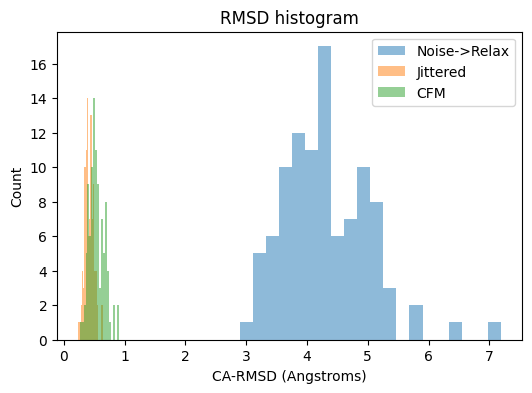

In [8]:
# @title
n = 100

base_jit_can  = baseline_jittered_native_can(loop_rel, n=100, jitter=0.3, seed=0)   # (n,L,3)
base_noise_can= baseline_noise_relax_can(L=loop_rel.shape[0], n=100, noise_scale=3.0, seed=0)

cfm_global_euler_can = sample(n=n, steps=100, noise_scale=3.0, fw_center= fw_center, U=U)

native_abs    = invert_canonical_batch(loop_rel, fw_center, U)
jit_abs       = invert_canonical_batch(base_jit_can, fw_center, U)
noise_abs     = invert_canonical_batch(base_noise_can, fw_center, U)
cfm_abs       = invert_canonical_batch(cfm_global_euler_can, fw_center, U)

jit_abs_aln   = batch_align_on_loop(jit_abs,   native_abs)
noise_abs_aln = batch_align_on_loop(noise_abs, native_abs)
cfm_abs_aln   = batch_align_on_loop(cfm_abs,   native_abs) if cfm_abs is not None else None

df_jit = eval_samples(jit_abs_aln, loop_xyz, fw_xyz, title='Jittered native')
df_noise = eval_samples(noise_abs_aln, loop_xyz, fw_xyz, title='Noise->Relax')
df_cfm_ge = eval_samples(cfm_abs_aln, loop_xyz, fw_xyz, title='CFM global + Euler')
plot_rmsd_hist([df_noise, df_jit, df_cfm_ge],
                   ['Noise->Relax','Jittered','CFM'])

## **Visual Evaluation**
Before comparing the generated and native loops, we rigidly align each predicted structure to the native one using the Kabsch algorithm, which finds the optimal rotation and translation minimizing RMSD. This step ensures that differences reflect genuine shape deviations rather than arbitrary spatial orientation.

This figure shows a 3D comparison between the native antibody loop (black) and the loops generated by different methods after structural alignment.
In the plot, the orange lines represent the initial random loops (Noise→Relax baseline), which - as expected - are highly disordered and far from the native geometry. The blue lines show the jittered natives, which closely follow the black native backbone since they are only slightly perturbed. **The green lines, corresponding to the CFM-generated loops, cluster tightly around the native structure, showing that the learned flow field successfully transforms noisy inputs into the realistic, native-like conformation**.

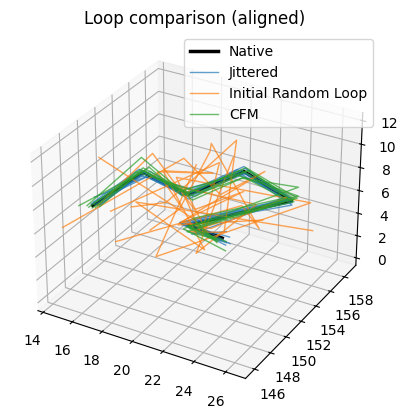

In [9]:
# @title
jit_abs_aln   = batch_align_on_loop(jit_abs,   native_abs)
noise_abs_aln = batch_align_on_loop(noise_abs, native_abs)
cfm_abs_aln   = batch_align_on_loop(cfm_abs,   native_abs) if cfm_abs is not None else None

sample_dict = {
    "Jittered": jit_abs_aln,
}
if cfm_abs_aln is not None:
    sample_dict["Initial Random Loop"] = noise_abs_aln
    sample_dict["CFM"] = cfm_abs_aln

plot_all_loops_3d(native_abs, sample_dict, k=7, title="Loop comparison (aligned)")


## **Next Steps and Random Thoughts**

- The next obvious step is to train the model on thousands of different antibodies (maybe only selecting the same region, or not, to be tested) to see how we can generate physically-relevant loops from unseen antibody frameworks. This is actually why this is coded on google colab, to make use of GPU in the next training steps on thousands of antibodies.
- I want to integrate a conditional flow matching approach in the https://github.com/RosettaCommons/RFdiffusion git to see if we can generate better antibodies with the CFM approach (which is less computionally demanding!)
- Finally, after promising results, it would be interesting to code a model to infer the aa sequences to the pre-defined geometrical loops using NLP approaches.


